In [1]:
import os

# Set the environment variable 'TF_CPP_MIN_LOG_LEVEL' to '3'.
# This suppresses most of TensorFlow's logging output, keeping the console clean.
# Levels: 0 = all logs, 1 = no info, 2 = no warnings, 3 = no errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set the environment variable 'TF_ENABLE_ONEDNN_OPTS' to '0'.
# This disables oneDNN/MKL optimizations in TensorFlow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import r2_score

from geexhp import datavis as dvis
dvis.configure_matplotlib()

In [2]:
# This strategy is used for synchronous distributed training across multiple GPUs or machines.
# It replicates the model on each device and splits the input data evenly for parallel processing.
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [3]:
# Define a function named 'parse_example' that takes three arguments:
# - 'example_proto': A serialized example (e.g., from a TFRecord file).
# - 'input': A dictionary defining the expected input features and their types.
# - 'output': A dictionary defining the expected output features and their types.
def parse_example(example_proto, input, output):
    # Define an inner function named '_dense_features_process' that takes one argument:
    # - 'parsed_features': A dictionary of feature descriptions used to parse the example.
    def _dense_features_process(parsed_features):
        # Parse a single example from the serialized 'example_proto' using the provided feature descriptions.
        # This converts the serialized data into a dictionary of tensors.
        parsed_features = tf.io.parse_single_example(example_proto, parsed_features)

        # Process the parsed features to ensure all values are dense tensors.
        # If a feature is a SparseTensor, convert it to a dense tensor with a default value of 0.0.
        # If a feature is already a dense tensor, leave it unchanged.
        dense_features_input = {
            key: tf.sparse.to_dense(value, default_value=0.0)
            if isinstance(value, tf.SparseTensor) else value
            for key, value in parsed_features.items()
        }

        return dense_features_input

    parsed_input = _dense_features_process(input)
    parsed_output = _dense_features_process(output)

    return parsed_input, parsed_output

In [4]:
# Define a function named 'read_tfrecord' that takes two arguments:
# - 'file': The path to the TFRecord file to read.
# - 'batch_size': The number of examples to include in each batch (default is 256).
def read_tfrecord(file, batch_size=256):
    # Define dictionaries that describes the input (and output) features in the TFRecord file.
    # Each key corresponds to a feature name, and the value specifies the feature's type and shape.
    # Here, all input features are variable-length (sparse) float32 features.
    input = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    output = {
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "LOG-OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
        "LOG-ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
        "BAR-ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

        'log_C2H6': tf.io.FixedLenFeature([], tf.float32),
        'log_CH4': tf.io.FixedLenFeature([], tf.float32),
        'log_CO': tf.io.FixedLenFeature([], tf.float32),
        'log_CO2': tf.io.FixedLenFeature([], tf.float32),
        'log_H2O': tf.io.FixedLenFeature([], tf.float32),
        'log_N2': tf.io.FixedLenFeature([], tf.float32),
        'log_N2O': tf.io.FixedLenFeature([], tf.float32),
        'log_O2': tf.io.FixedLenFeature([], tf.float32),
        'log_O3': tf.io.FixedLenFeature([], tf.float32)
    }

    # Read the TFRecord file using TensorFlow's 'TFRecordDataset' class.
    # The 'num_parallel_reads' argument is set to 'tf.data.AUTOTUNE' to automatically optimize
    # the number of parallel reads based on available resources.
    dataset = tf.data.TFRecordDataset(file, num_parallel_reads=tf.data.AUTOTUNE)

    # Apply the 'parse_example' function to each example in the dataset to parse the serialized data.
    # The 'num_parallel_calls' argument is set to 'tf.data.AUTOTUNE' to optimize parallelism.
    parsed_dataset = dataset.map(lambda x: parse_example(x, input, output), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the parsed dataset into groups of 'batch_size' examples.
    # The 'drop_remainder' argument is set to 'False' to include smaller batches at the end of the dataset.
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)

    # Prefetch data to improve performance by overlapping data preprocessing and model execution.
    # The 'tf.data.AUTOTUNE' argument allows TensorFlow to automatically determine the optimal buffer size.
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    # Use the 'interleave' method to create a dataset that cycles through the parsed dataset.
    # This is useful for ensuring that the dataset is shuffled and balanced during training.
    # The 'num_parallel_calls' argument is set to 'tf.data.AUTOTUNE' for optimal parallelism.
    parsed_dataset = tf.data.Dataset.range(1).interleave(lambda _: parsed_dataset, num_parallel_calls=tf.data.AUTOTUNE)

    return parsed_dataset

In [5]:
# The number of training samples in the dataset.
TRAIN_SAMPLES = 818862

# THe number of validation samples in the dataset.
VAL_SAMPLES = 79031

# Define the batch size to use for training, validation, and testing.
# A batch size of 256 means that the model will process 256 samples at a time.
BATCH_SIZE = 256

# Calculate the number of steps per epoch for training.
# This is the number of batches required to process the entire training dataset.
# The 'np.ceil' function ensures that we round up to the nearest integer to include all samples.
steps_per_epoch = int(np.ceil(TRAIN_SAMPLES / BATCH_SIZE))

# The same for the number of steps for validation.
val_steps = int(np.ceil(VAL_SAMPLES / BATCH_SIZE))

# Create the training dataset
train_ds = read_tfrecord("../data/train.tfrecord", batch_size=BATCH_SIZE)

# Create the validation dataset 
val_ds = read_tfrecord("../data/val.tfrecord", batch_size=BATCH_SIZE)

# Create the test dataset
test_ds = read_tfrecord("../data/test.tfrecord", batch_size=BATCH_SIZE)

In [6]:
# def count_samples(dataset: tf.data.Dataset):
#     """
#     Count the total number of samples in a dataset by iterating once.
#     If the dataset is batched, unbatch it first.
#     """
#     count = 0
#     for _ in dataset.unbatch():
#         count += 1
#     return count

# TRAIN_SAMPLES = count_samples(train_ds)
# print("Train samples:", TRAIN_SAMPLES)      # 818862

# VAL_SAMPLES = count_samples(val_ds)
# print("Validation samples:", VAL_SAMPLES)   # 79031

# BATCH_SIZE = 1000 # Must match read_tfrecord batch_size
# steps_per_epoch = TRAIN_SAMPLES // BATCH_SIZE
# validation_steps = VAL_SAMPLES // BATCH_SIZE

In [7]:
# Define a function that constructs and compiles a multi-output neural network model.
def build_model():
    # Define a list of output names. These correspond to the target variables the model will predict.
    outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "LOG-OBJECT-GRAVITY",
        "LOG-ATMOSPHERE-TEMPERATURE",
        "BAR-ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]

    # ----------------------
    # 1. Input Processing
    # ----------------------
    # Define separate input layers for each spectral range (UV, Visible, and NIR).
    # Each input layer has a specific shape corresponding to the dimensions of the input data.
    input_uv = tf.keras.layers.Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = tf.keras.layers.Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = tf.keras.layers.Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')

    # ----------------------
    # 2. Spectral Feature Extraction Branches
    # ----------------------
    # Define a helper function to create a feature extraction branch for each spectral range.
    # This function applies convolutional layers, batch normalization, skip connections, and pooling.
    def create_branch(input_layer, filters, kernel_size, pool_size=2):
        x = input_layer
        for f in filters:
            # Initial convolution with a smaller kernel (3x1) to capture local patterns.
            x_init = tf.keras.layers.Conv1D(f, 3, padding='same', 
                                        kernel_initializer='he_normal')(x)
            x_init = tf.keras.layers.BatchNormalization()(x_init)
            
            # Main path: Apply a convolution with the specified kernel size.
            x = tf.keras.layers.Conv1D(f, kernel_size, padding='same',
                                    kernel_initializer='he_normal')(x_init)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('swish')(x)  # Swish activation for better performance.
            
            # Add a skip connection to combine the initial and main paths.
            x = tf.keras.layers.Add()([x_init, x])
            
            # Apply average pooling to downsample the feature maps.
            # Using strides=1 and padding='same' ensures less aggressive downsampling.
            x = tf.keras.layers.AveragePooling1D(
                pool_size=pool_size, 
                strides=1,  
                padding='same'
            )(x)
        return x

    # Create a feature extraction branch for the UV spectral range.
    uv_branch = create_branch(input_uv, filters=[16, 32], kernel_size=3)
    
    # Create a feature extraction branch for the Visible spectral range.
    vis_branch = create_branch(input_vis, filters=[32, 64, 128], kernel_size=7, pool_size=3)
    
    # Create a feature extraction branch for the NIR spectral range.
    nir_branch = create_branch(input_nir, filters=[32, 64], kernel_size=5)

    # ----------------------
    # 3. Cross-Spectral Attention Fusion
    # ----------------------
    # Define a Squeeze-and-Excitation (SE) block to enhance important features.
    def squeeze_excite(x, ratio=8):
        filters = x.shape[-1]  # Number of filters in the input feature map.
        se = tf.keras.layers.GlobalAveragePooling1D()(x)  # Global average pooling.
        se = tf.keras.layers.Dense(filters//ratio, activation='swish')(se)  # Dense layer with Swish activation.
        se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)  # Dense layer with Sigmoid activation.
        return tf.keras.layers.Multiply()([x, se])  # Multiply the input feature map with the SE weights.

    # Apply the SE block to each spectral branch to enhance important features.
    uv_branch = squeeze_excite(uv_branch)
    vis_branch = squeeze_excite(vis_branch)
    nir_branch = squeeze_excite(nir_branch)

    # Concatenate the global average pooled features from all branches.
    merged = tf.keras.layers.concatenate([
        tf.keras.layers.GlobalAveragePooling1D()(uv_branch),
        tf.keras.layers.GlobalAveragePooling1D()(vis_branch),
        tf.keras.layers.GlobalAveragePooling1D()(nir_branch)
    ])

    # ----------------------
    # 4. Dense Processing with Skip Connections
    # ----------------------
    # Apply dense layers to process the concatenated features.
    x = tf.keras.layers.Dense(512, activation='swish')(merged)
    x = tf.keras.layers.Dropout(0.3)(x)  # Dropout for regularization.
    x = tf.keras.layers.BatchNormalization()(x)  # Batch normalization for stability.
    
    x = tf.keras.layers.Dense(256, activation='swish')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # ----------------------
    # 5. Output Heads
    # ----------------------
    # Create separate output heads for each target variable.
    outputs = {}
    loss_weights = {}
    for output_name in outputs_list:
        # Add a dense layer with 64 units and Swish activation for each output head.
        head = tf.keras.layers.Dense(64, activation='swish')(x)
        head = tf.keras.layers.Dropout(0.2)(head)
        # Add a final dense layer with 1 unit (for regression) and name it after the target variable.
        outputs[output_name] = tf.keras.layers.Dense(1, name=output_name)(head)
        
        # Assign loss weights based on the scale of the target variable.
        if 'LOG-' in output_name or 'log_' in output_name:
            loss_weights[output_name] = 1.0  # Higher weight for logarithmic outputs.
        else:
            loss_weights[output_name] = 0.5  # Lower weight for linear outputs.

    # ----------------------
    # 6. Model Compilation
    # ----------------------
    # Define the model by specifying its inputs and outputs.
    model = tf.keras.Model(
        inputs=[input_uv, input_vis, input_nir],
        outputs=outputs
    )

    # Define loss functions for each output.
    # Use Huber loss for robustness, with different delta values for logarithmic and linear outputs.
    losses = {output_name: tf.keras.losses.Huber(delta=0.5) 
        if 'LOG-' in output_name or 'log_' in output_name
        else tf.keras.losses.Huber(delta=2.0) 
        for output_name in outputs_list}

    # Define the optimizer with a custom learning rate, weight decay, and gradient clipping.
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-5,  # Start with a lower learning rate.
        weight_decay=1e-6,  # Weight decay for regularization.
        global_clipnorm=1.0  # Gradient clipping to prevent exploding gradients.
    )

    # Compile the model with the optimizer, loss functions, and loss weights.
    model.compile(
        optimizer=optimizer,
        loss=losses,  # Use Huber loss for robustness.
        loss_weights=loss_weights,  # Assign weights to balance the losses.
    )

    # Return the compiled model.
    return model

In [8]:
# Define a list of callbacks to be used during model training.
# Callbacks are functions that are executed at specific stages of the training process.
callbacks = [
    # EarlyStopping callback: Stops training when the validation loss stops improving.
    tf.keras.callbacks.EarlyStopping(
        patience=5,  # Number of epochs to wait after the last improvement in validation loss.
        restore_best_weights=True,  # Restore the model weights from the epoch with the best validation loss.
        monitor='val_loss'  # Metric to monitor for early stopping (validation loss in this case).
    )
]

# Build the model
model = build_model()

# Train the model
history = model.fit(
    train_ds,  # Training dataset (batched and prefetched).
    epochs=30,  # Maximum number of epochs to train the model.
    #steps_per_epoch=steps_per_epoch,  # Number of batches per epoch 
    validation_data=val_ds,  # Validation dataset (batched and prefetched).
    #validation_steps=val_steps,  # Number of batches to use for validation 
    callbacks=callbacks,  # List of callbacks to use during training
    verbose=1  # Verbosity mode: 1 = progress bar, 0 = silent, 2 = one line per epoch.
)

Epoch 1/30
   3199/Unknown 622s 191ms/step - BAR-ATMOSPHERE-PRESSURE_loss: 0.2415 - LOG-ATMOSPHERE-TEMPERATURE_loss: 0.6164 - LOG-OBJECT-GRAVITY_loss: 0.2477 - OBJECT-RADIUS-REL-EARTH_loss: 0.3291 - log_C2H6_loss: 0.3032 - log_CH4_loss: 1.3971 - log_CO2_loss: 0.8210 - log_CO_loss: 1.3776 - log_H2O_loss: 1.0261 - log_N2O_loss: 2.1980 - log_N2_loss: 0.2222 - log_O2_loss: 0.4132 - log_O3_loss: 1.8199 - loss: 11.0131

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3199/3199 ━━━━━━━━━━━━━━━━━━━━ 636s 195ms/step - BAR-ATMOSPHERE-PRESSURE_loss: 0.2415 - LOG-ATMOSPHERE-TEMPERATURE_loss: 0.6164 - LOG-OBJECT-GRAVITY_loss: 0.2476 - OBJECT-RADIUS-REL-EARTH_loss: 0.3290 - log_C2H6_loss: 0.3033 - log_CH4_loss: 1.3969 - log_CO2_loss: 0.8209 - log_CO_loss: 1.3774 - log_H2O_loss: 1.0260 - log_N2O_loss: 2.1978 - log_N2_loss: 0.2222 - log_O2_loss: 0.4132 - log_O3_loss: 1.8198 - loss: 11.0121 - val_BAR-ATMOSPHERE-PRESSURE_loss: 0.0469 - val_LOG-ATMOSPHERE-TEMPERATURE_loss: 0.0290 - val_LOG-OBJECT-GRAVITY_loss: 0.0115 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.0416 - val_log_C2H6_loss: 1.5728 - val_log_CH4_loss: 0.6373 - val_log_CO2_loss: 0.3919 - val_log_CO_loss: 0.7802 - val_log_H2O_loss: 0.3218 - val_log_N2O_loss: 1.9145 - val_log_N2_loss: 0.0279 - val_log_O2_loss: 0.3784 - val_log_O3_loss: 1.7563 - val_loss: 7.9412
Epoch 2/30
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 633s 198ms/step - BAR-ATMOSPHERE-PRESSURE_loss: 0.1050 - LOG-ATMOSPHERE-TEMPERATURE_loss: 0.1904 - LOG-OBJEC

In [21]:
def huber_loss(y_true, y_pred, delta):
    error = y_pred - y_true
    return np.mean(np.where(np.abs(error) < delta, 
                           0.5 * error**2, 
                           delta * (np.abs(error) - 0.5 * delta)))

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Train Loss', marker="o")
    plt.plot(history.history['val_loss'], label='Validation Loss', marker="o")
    plt.title('Total Loss Evolution')
    plt.ylabel('Huber Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def plot_prediction_analysis(y_true, y_pred, outputs_list):
    n_outputs = len(outputs_list)
    n_cols = 4
    n_rows = int(np.ceil(n_outputs / n_cols))
    
    plt.figure(figsize=(15, 4*n_rows))
    
    for i, name in enumerate(outputs_list):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Calculate metrics
        delta = 0.5 if ('LOG-' in name or 'log_' in name) else 2.0
        h_loss = huber_loss(y_true[name], y_pred[name], delta)
        r2 = r2_score(y_true[name], y_pred[name])
        
        # Scatter plot
        plt.scatter(y_true[name], y_pred[name], alpha=0.3, s=10)
        lims = [np.min([y_true[name], y_pred[name]]), 
                np.max([y_true[name], y_pred[name]])]
        plt.plot(lims, lims, color="tab:red", ls='--')
        
        plt.title(f'{name}\nHuber(δ={delta}): {h_loss:.3f}, R²: {r2:.3f}')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
    
    plt.tight_layout()
    plt.show()

def plot_residual_analysis(y_true, y_pred, outputs_list):
    n_outputs = len(outputs_list)
    n_cols = 4
    n_rows = int(np.ceil(n_outputs / n_cols))
    
    plt.figure(figsize=(15, 4*n_rows))
    
    for i, name in enumerate(outputs_list):
        plt.subplot(n_rows, n_cols, i+1)
        
        residuals = y_pred[name] - y_true[name]
        delta = 0.5 if ('LOG-' in name or 'log_' in name) else 2.0
        h_loss = huber_loss(y_true[name], y_pred[name], delta)
        
        # Hexbin plot for density
        plt.hexbin(y_true[name], residuals, gridsize=50, cmap='viridis', bins='log')
        plt.colorbar(label='Log count', pad=0)
        plt.axhline(0, color='tab:red', linestyle='--')
        plt.title(f'Residuals: {name}\nHuber(δ={delta}): {h_loss:.3f}')
        plt.xlabel('True Values')
        plt.ylabel('Residuals (Pred - True)')
    
    plt.tight_layout()
    plt.show()

In [16]:
outputs_list = [
        "OBJECT-RADIUS-REL-EARTH",
        "LOG-OBJECT-GRAVITY",
        "LOG-ATMOSPHERE-TEMPERATURE",
        "BAR-ATMOSPHERE-PRESSURE",
        'log_C2H6',
        'log_CH4',
        'log_CO',
        'log_CO2',
        'log_H2O',
        'log_N2',
        'log_N2O',
        'log_O2',
        'log_O3'
    ]

# Generate predictions
y_true = {name: [] for name in outputs_list}
y_pred = {name: [] for name in outputs_list}

for batch in test_ds:
    inputs, targets = batch
    predictions = model.predict(inputs, verbose=0)
    
    for name in outputs_list:
        y_true[name].extend(targets[name].numpy())
        y_pred[name].extend(predictions[name].flatten())

# Convert to numpy arrays
for name in outputs_list:
    y_true[name] = np.array(y_true[name])
    y_pred[name] = np.array(y_pred[name])

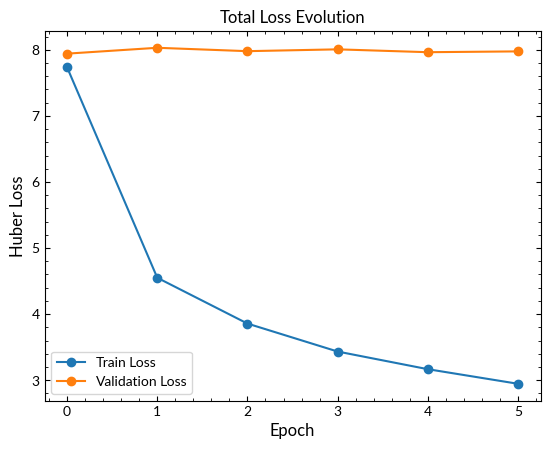

In [22]:
plot_training_history(history)

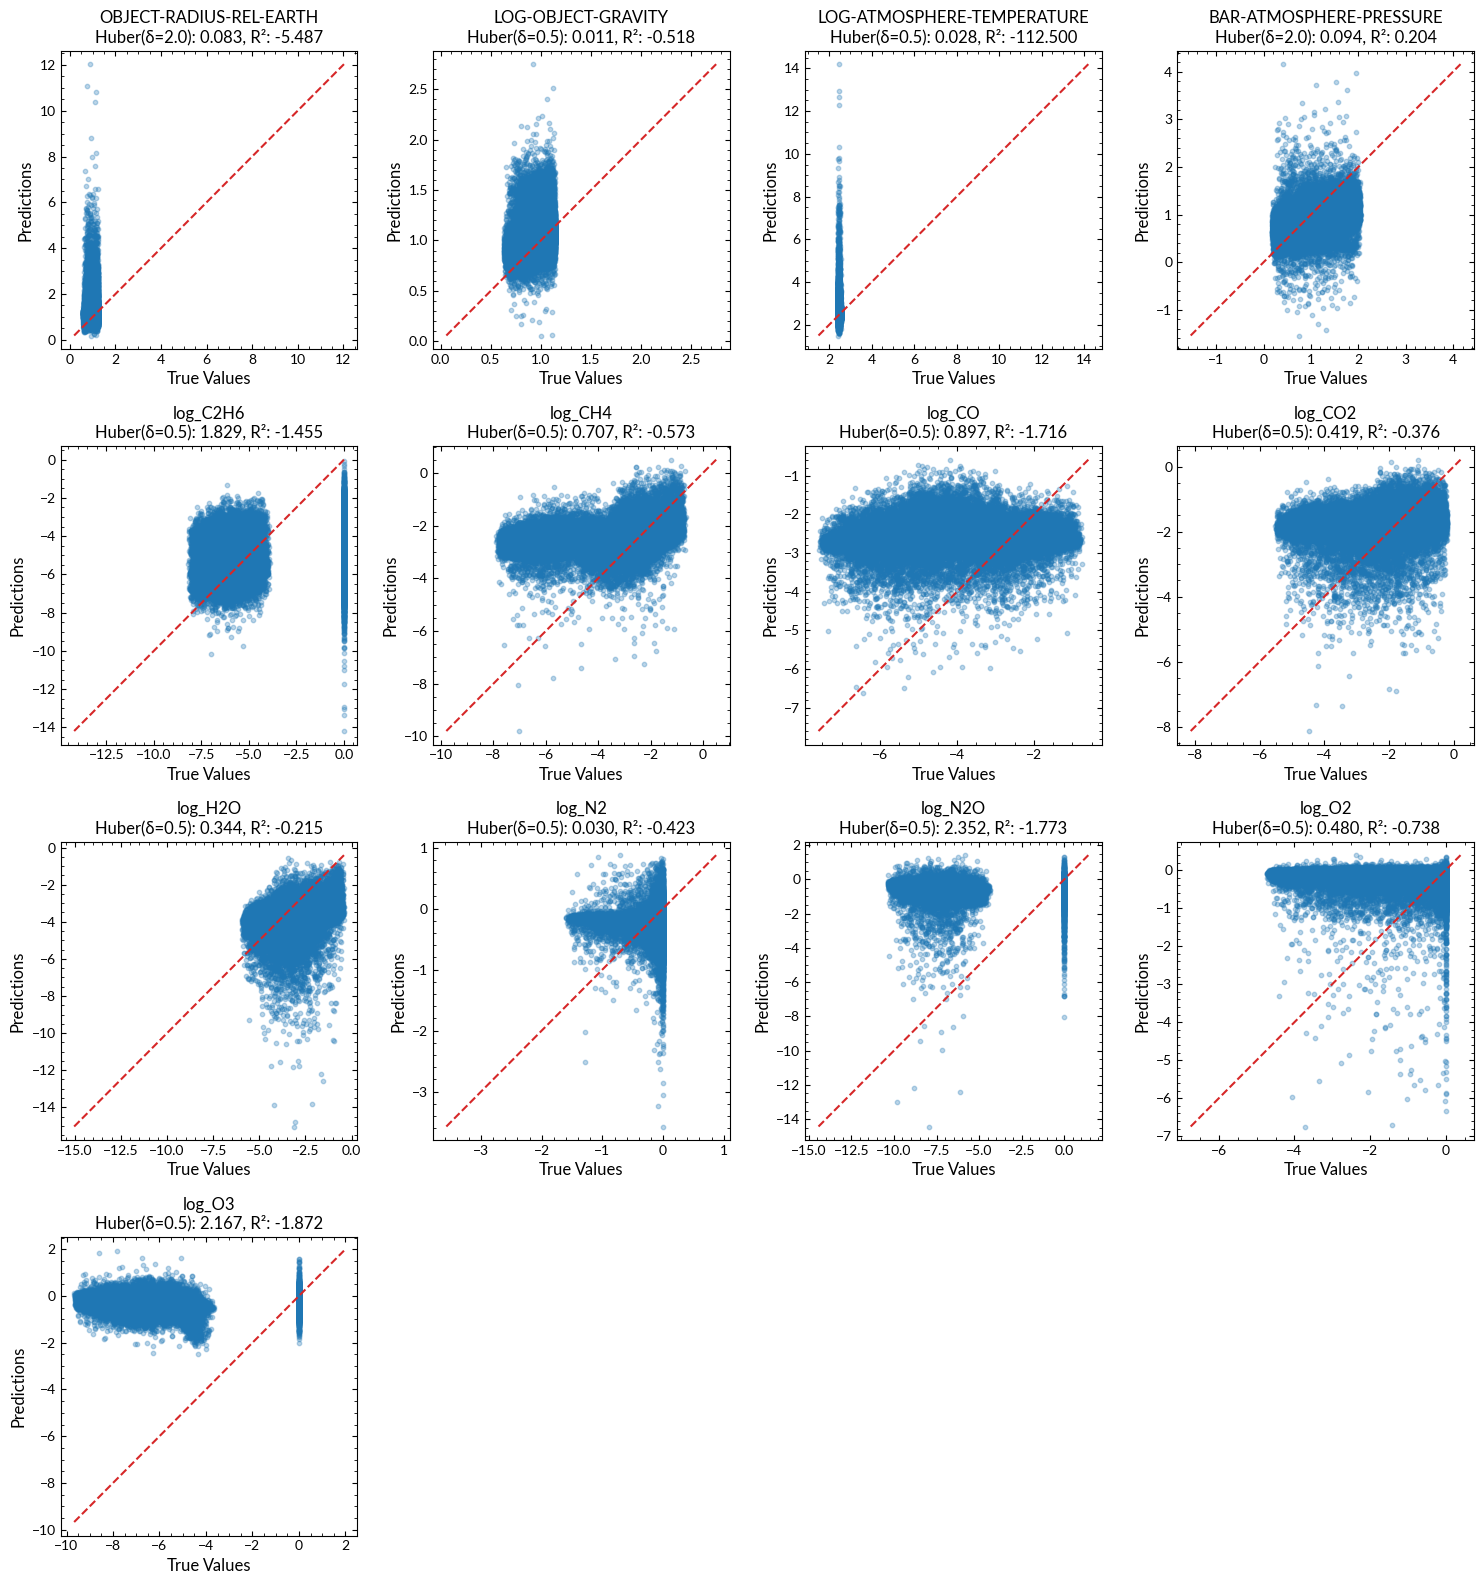

In [23]:
plot_prediction_analysis(y_true, y_pred, outputs_list)

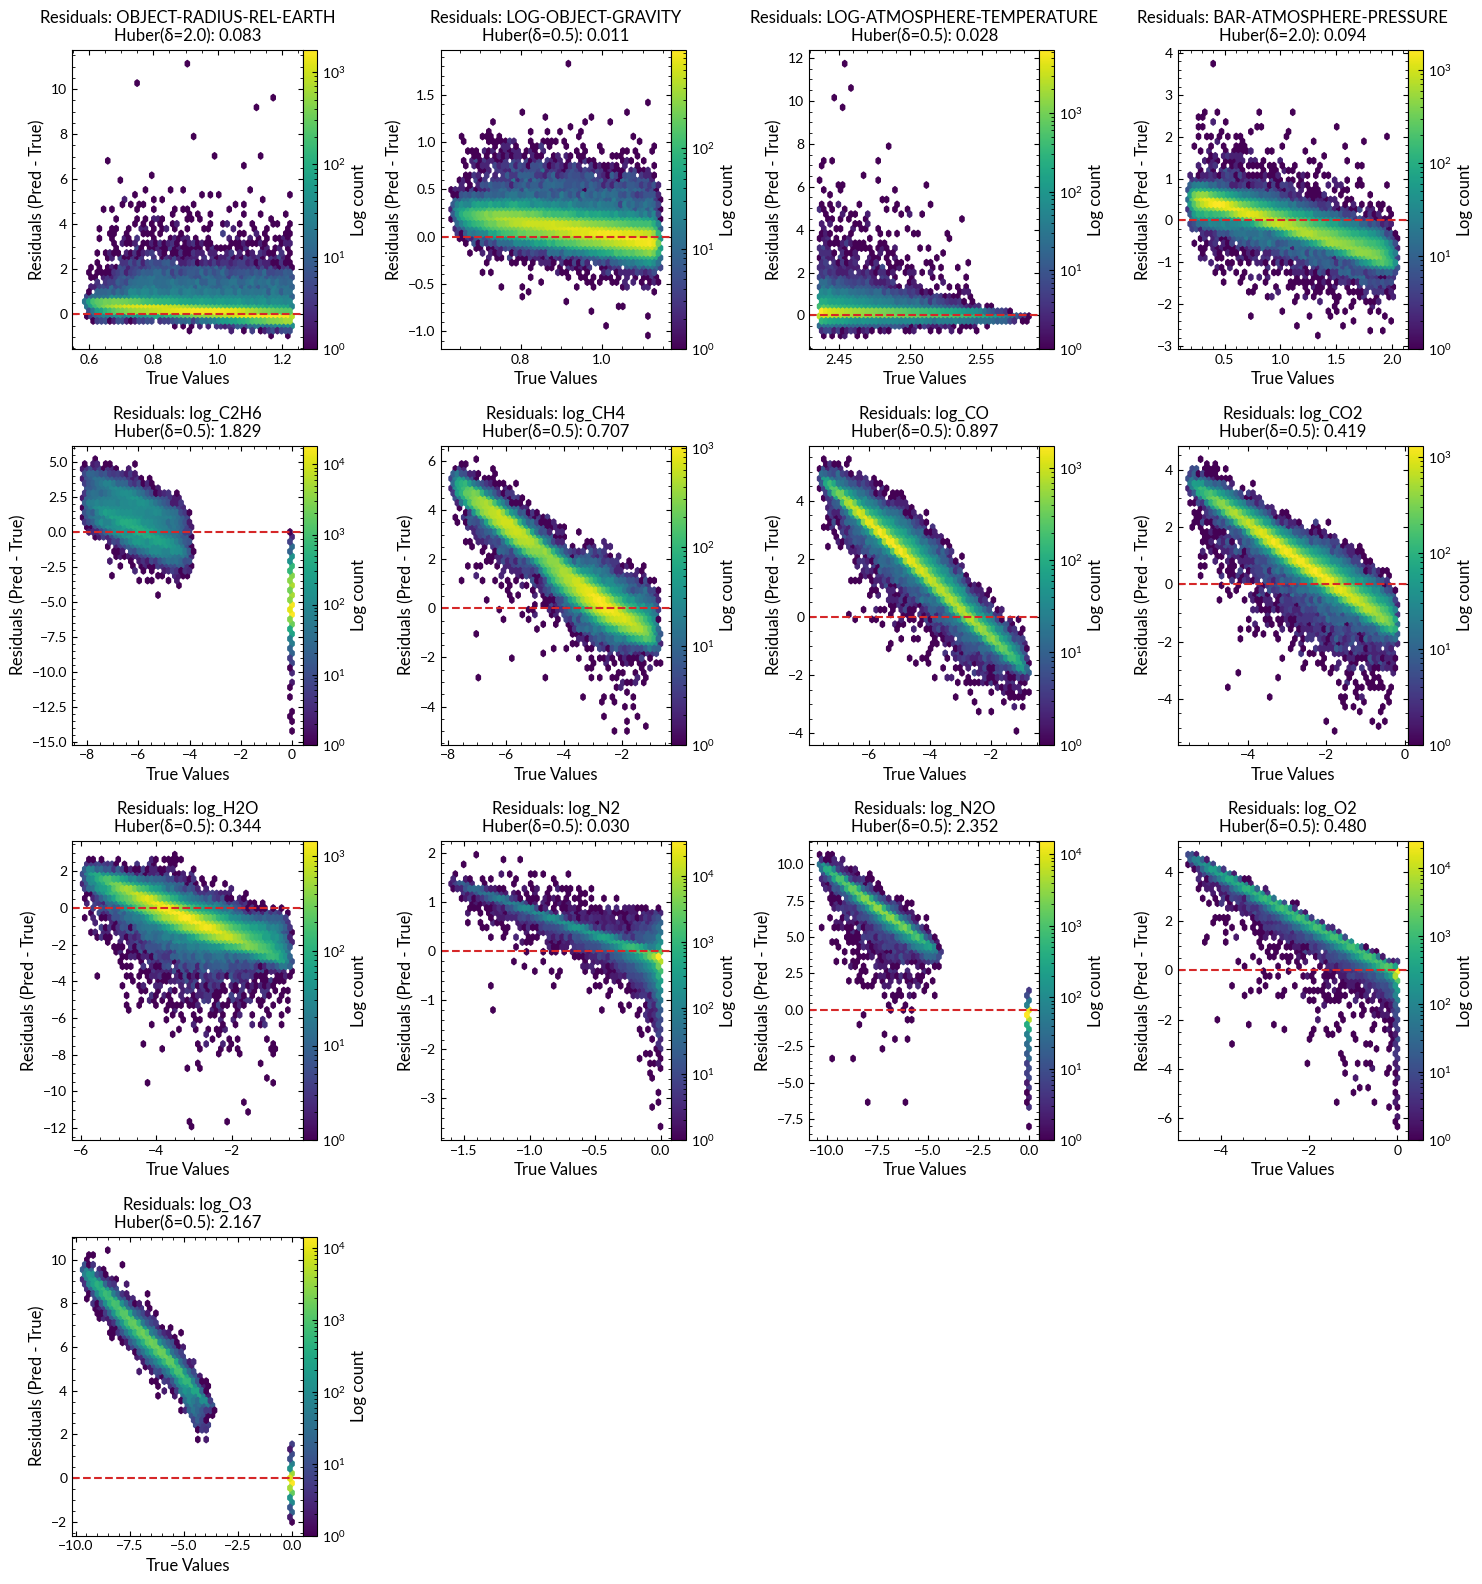

In [13]:
# Good Model: 
# Residuals clustered near 0    
# Symmetric around red line

plot_residual_analysis(y_true, y_pred, outputs_list)